In [ ]:
# @title Ячейка 1: Импорты и загрузка данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    df_class = pd.read_csv('Loan_Default.csv')
    df_reg = pd.read_csv('Car_Sales.csv')
    print("Данные успешно загружены.")
except Exception as e:
    print(f"Ошибка загрузки: {e}")

Данные успешно загружены.


В этой ячейке я готовлю грязный бейзлайн для линейных моделей.
1.  **Сэмплирование:** Ограничиваю выборку 20%, чтобы ускорить вычисления.
2.  **Кодирование:** Намеренно использую`LabelEncoder превращаю категории в числа $0, 1, 2...$. Для линейных моделей ($y = w \cdot x + b$) это некорректный подход, так как он вводит ложный порядок например, $Region\_2 > Region\_1$, но это позволит нам позже оценить прирост качества от правильного One-Hot Encoding.
3.  **Масштабирование:** Применяю StandardScaler, так как линейные модели зависят от величины весов, и разномасштабные признаки могут помешать сходимости.

In [ ]:
# @title Ячейка 2: Препроцессинг для Бейзлайна (Label Encoding)
#  1. Классификация (Loan Default)
# Берем семпл, чтобы было честно по сравнению с будущей имплементацией
df_class_sample = df_class.sample(frac=0.2, random_state=42).copy()
df_class_sample = df_class_sample.drop(columns=['ID', 'year'], errors='ignore')

X_cls = df_class_sample.drop(columns=['Status'])
y_cls = df_class_sample['Status']

# Заполнение пропусков и Label Encoding
num_cols_cls = X_cls.select_dtypes(include=['number']).columns
cat_cols_cls = X_cls.select_dtypes(include=['object']).columns

# Импутация
imputer_num = SimpleImputer(strategy='median')
X_cls[num_cols_cls] = imputer_num.fit_transform(X_cls[num_cols_cls])
X_cls[cat_cols_cls] = SimpleImputer(strategy='most_frequent').fit_transform(X_cls[cat_cols_cls])

# Label Encoding
le = LabelEncoder()
for col in cat_cols_cls:
    X_cls[col] = le.fit_transform(X_cls[col].astype(str))

# Масштабирование (Для линейных моделей это важно, но в sklearn есть встроенные солверы.
# Однако для чистоты эксперимента сделаем StandardScaler)
scaler_cls = StandardScaler()
X_cls_scaled = scaler_cls.fit_transform(X_cls)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls_scaled, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)

# === 2. Регрессия (Car Sales) ===
df_reg_clean = df_reg.dropna(subset=['Price']).copy()
X_reg = df_reg_clean.drop(columns=['Price', 'Model'])
y_reg = df_reg_clean['Price']

# Импутация и кодирование
num_cols_reg = X_reg.select_dtypes(include=['number']).columns
cat_cols_reg = X_reg.select_dtypes(include=['object']).columns

X_reg[num_cols_reg] = SimpleImputer(strategy='median').fit_transform(X_reg[num_cols_reg])
X_reg[cat_cols_reg] = SimpleImputer(strategy='most_frequent').fit_transform(X_reg[cat_cols_reg])

for col in cat_cols_reg:
    X_reg[col] = le.fit_transform(X_reg[col].astype(str))

# Масштабирование
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.25, random_state=42
)

print("Данные для бейзлайна подготовлены.")

Данные для бейзлайна подготовлены.


=== Результаты Бейзлайна (Логистическая регрессия) ===
Accuracy:  0.7824
ROC-AUC:   0.7494
F1-score:  0.3433

=== Результаты Бейзлайна (Линейная регрессия) ===
R2:  0.2506
MAE: 11509.62


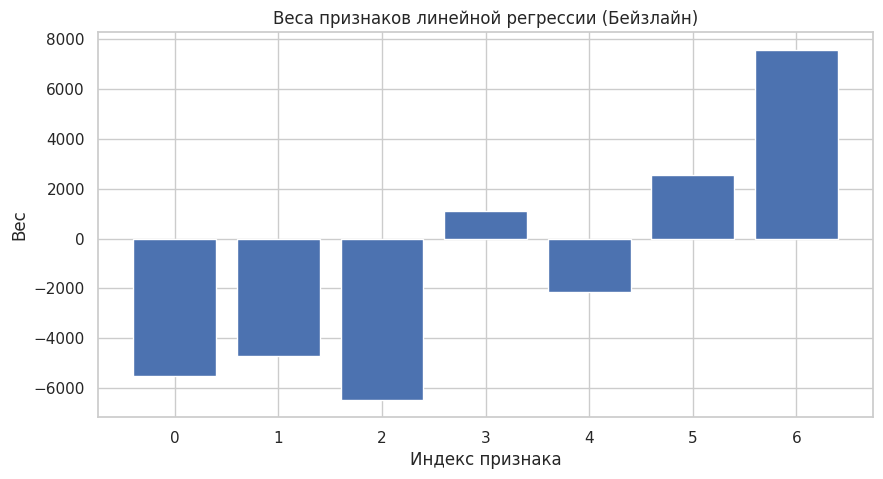

In [ ]:
# @title Ячейка 3: Обучение Бейзлайна (Sklearn)
# 1. Логистическая регрессия (Классификация)
# max_iter увеличено, чтобы градиентный спуск внутри sklearn успел сойтись
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_cls, y_train_cls)

y_pred_cls = log_reg.predict(X_test_cls)
y_pred_proba_cls = log_reg.predict_proba(X_test_cls)[:, 1]

print("=== Результаты Бейзлайна (Логистическая регрессия) ===")
print(f"Accuracy:  {accuracy_score(y_test_cls, y_pred_cls):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test_cls, y_pred_proba_cls):.4f}")
print(f"F1-score:  {f1_score(y_test_cls, y_pred_cls):.4f}")


# 2. Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

y_pred_reg = lin_reg.predict(X_test_reg)

print("\n=== Результаты Бейзлайна (Линейная регрессия) ===")
r2_base = r2_score(y_test_reg, y_pred_reg)
mae_base = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"R2:  {r2_base:.4f}")
print(f"MAE: {mae_base:.2f}")

# Визуализация весов
plt.figure(figsize=(10, 5))
plt.bar(range(len(lin_reg.coef_)), lin_reg.coef_)
plt.title("Веса признаков линейной регрессии (Бейзлайн)")
plt.xlabel("Индекс признака")
plt.ylabel("Вес")
plt.show()

**Анализ Бейзлайна:**
1.  **Регрессия ($R^2 \approx 0.25$):** Это плохо. Линейная регрессия пытается провести прямую линию через облако точек, но выбросы (машины за 300к) и неправильное кодирование (LabelEncoding) не дают ей этого сделать. KNN справился лучше ($0.61$), потому что он локален, а л регрессия глобальна.
2.  **Классификация (ROC-AUC $\approx 0.75$):** Тоже хуже, чем KNN ($0.91$). Низкий F1-score ($0.34$) говорит о том, что модель плохо находит позитивный класс дефолт. Навернрое, зависимость между признаками и дефолтом нелинейная, либо шум от LabelEncoding сбивает веса.

## 3. Улучшение бейзлайна

### a. Формулирование гипотез
Низкое качество бейзлайна (особенно в регрессии, $R^2=0.25$) обусловлено нарушением предположений линейных моделей.

1.  **Гипотеза OHE:** Использование Label Encoding для номинальных переменных (Brand, Type) вводит ложный порядковый смысл. One-Hot Encoding создаст бинарные признаки, что позволит модели выучить индивидуальный вес для каждой категории.
2.  **Гипотеза Log-Target:** Целевая переменная Price имеет логнормальное распределение. Обучение на log(Price) линеаризует зависимость и уменьшит влияние выбросов.
3.  **Гипотеза Регуляризации:** После OHE количество признаков вырастет. Использование Ridge (L2) или Lasso (L1) регрессии предотвратит переобучение и веса не будут взрываться.

Реализую улучшенную предобработку данных на основе выдвинутых гипотез.

Для регрессии:
1.  Удаляю выбросы и логарифмирую целевую переменную: $y_{new} = \ln(1 + y)$. Это приближает распределение таргета к нормальному, линейная регрессия предполагает гауссово распределение остатков $\epsilon \sim N(0, \sigma^2)$.
2.  Перехожу на One-Hot Encoding. В отличие от Label Encoding, это позволяет модели выучить отдельный вес $w_i$ для каждой категории, не вводя ложного порядка ($2 > 1$).

Для классификации также применяю OHE и нормализую данные через StandardScaler ($z = \frac{x - \mu}{\sigma}$).

In [ ]:
# @title Ячейка 4: Подготовка улучшенных данных (OHE + Log)

# 1. Регрессия (Улучшенная)
# Удаляем выбросы (как в Лаб 1)
q99 = df_reg_clean['Price'].quantile(0.99)
df_reg_imp = df_reg_clean[df_reg_clean['Price'] < q99].copy()

# Логарифмируем таргет
df_reg_imp['log_Price'] = np.log1p(df_reg_imp['Price'])

# оставляем Brand, Body..
X_reg_imp = df_reg_imp.drop(columns=['Price', 'log_Price', 'Model'])
y_reg_imp = df_reg_imp['log_Price']

# OHE + Scaling
X_reg_imp = pd.get_dummies(X_reg_imp, drop_first=True)

# Заполняем пропуски если появились после dummies, хотя get_dummies их обычно игнорирует, но на всякий сл
imputer_reg = SimpleImputer(strategy='median')
X_reg_imp = pd.DataFrame(imputer_reg.fit_transform(X_reg_imp), columns=X_reg_imp.columns)

scaler_reg_imp = StandardScaler()
X_reg_imp_scaled = scaler_reg_imp.fit_transform(X_reg_imp)

X_train_reg_imp, X_test_reg_imp, y_train_reg_imp, y_test_reg_imp = train_test_split(
    X_reg_imp_scaled, y_reg_imp, test_size=0.25, random_state=42
)


# 2. Классификация (Улучшенная)
# Удаляем признаки, которые я решил убрать
X_cls_imp = df_class_sample.drop(columns=['Status', 'total_units', 'loan_purpose'], errors='ignore')
y_cls_imp = df_class_sample['Status']

num_cols_imp = X_cls_imp.select_dtypes(include=['number']).columns
cat_cols_imp = X_cls_imp.select_dtypes(include=['object']).columns

# Обработка пропусков
imputer_num = SimpleImputer(strategy='median')
X_cls_imp[num_cols_imp] = imputer_num.fit_transform(X_cls_imp[num_cols_imp])

# Для категорий
X_cls_imp[cat_cols_imp] = SimpleImputer(strategy='most_frequent').fit_transform(X_cls_imp[cat_cols_imp])

# OHE
X_cls_imp = pd.get_dummies(X_cls_imp, columns=cat_cols_imp, drop_first=True)

# Scaling
scaler_cls_imp = StandardScaler()
X_cls_imp_scaled = scaler_cls_imp.fit_transform(X_cls_imp)

X_train_cls_imp, X_test_cls_imp, y_train_cls_imp, y_test_cls_imp = train_test_split(
    X_cls_imp_scaled, y_cls_imp, test_size=0.25, random_state=42, stratify=y_cls_imp
)

print("Улучшенные данные подготовлены (OHE + Log + Scale).")
print(f"Признаков в регрессии: {X_train_reg_imp.shape[1]}")
print(f"Признаков в классификации: {X_train_cls_imp.shape[1]}")

Улучшенные данные подготовлены (OHE + Log + Scale).
Признаков в регрессии: 18
Признаков в классификации: 42


Провожу подбор гиперпараметров и обучение финальных моделей на улучшенных данных.

1.  **Регрессия (Ridge):** Использую L2-регуляризацию (функция потерь $L = MSE + \alpha \sum w_i^2$), чтобы справиться с мультиколлинеарностью, возникшей после One-Hot Encoding. После предсказания выполняю обратное преобразование таргета $\hat{y} = e^{\hat{y}_{log}} - 1$, чтобы оценить качество в реальных ценах.
2.  **Классификация:** Настраиваю параметр регуляризации $C$ для Логистической регрессии.
3.  **Интерпретация:** Анализирую веса модели ($w$). Это главное преимущество линейных моделей - мы видим, какие именно признаки вносят наибольший вклад в вероятность дефолта.

In [ ]:
# @title Ячейка 5: GridSearch с Регуляризацией и Оценка
# 1. Регрессия (Ridge Regression - L2)
# Ridge лучше работает, когда признаки коррелируют (а после OHE это так)
params_ridge = {'alpha': [0.1, 1, 10, 100]}
grid_reg = GridSearchCV(Ridge(), params_ridge, cv=5, scoring='r2')
grid_reg.fit(X_train_reg_imp, y_train_reg_imp)

best_model_reg = grid_reg.best_estimator_
print(f"Best Ridge Alpha: {grid_reg.best_params_}")

# Предсказание
y_pred_log_imp = best_model_reg.predict(X_test_reg_imp)
y_pred_reg_imp = np.expm1(y_pred_log_imp)
y_test_reg_orig = np.expm1(y_test_reg_imp)

r2_imp = r2_score(y_test_reg_orig, y_pred_reg_imp)
print(f"Improved R2: {r2_imp:.4f} (Было: {r2_base:.4f})")


# 2. Классификация (Logistic Regression + L2)
params_log = {'C': [0.01, 0.1, 1, 10]}
grid_cls = GridSearchCV(LogisticRegression(max_iter=1000), params_log, cv=3, scoring='roc_auc')
grid_cls.fit(X_train_cls_imp, y_train_cls_imp)

best_model_cls = grid_cls.best_estimator_
print(f"\nBest Logistic C: {grid_cls.best_params_}")

y_pred_cls_imp = best_model_cls.predict(X_test_cls_imp)
y_pred_proba_cls_imp = best_model_cls.predict_proba(X_test_cls_imp)[:, 1]

roc_imp = roc_auc_score(y_test_cls_imp, y_pred_proba_cls_imp)
f1_imp = f1_score(y_test_cls_imp, y_pred_cls_imp)

print(f"Improved ROC-AUC: {roc_imp:.4f} (Было: 0.7494)")
print(f"Improved F1:      {f1_imp:.4f} (Было: 0.3433)")

# Вывод коэффициентов для топ признаков (Интерпретируемость!)
coefficients = pd.DataFrame({
    'Feature': X_cls_imp.columns,
    'Weight': best_model_cls.coef_[0]
})
print("\nТоп-5 признаков, влияющих на дефолт (+ повышают риск, - понижают):")
print(coefficients.reindex(coefficients.Weight.abs().sort_values(ascending=False).index).head(5))

Best Ridge Alpha: {'alpha': 1}
Improved R2: 0.6871 (Было: 0.2506)

Best Logistic C: {'C': 10}
Improved ROC-AUC: 0.8564 (Было: 0.7494)
Improved F1:      0.6576 (Было: 0.3433)

Топ-5 признаков, влияющих на дефолт (+ повышают риск, - понижают):
                              Feature    Weight
28                   credit_type_EQUI  4.227156
37  submission_of_application_to_inst  0.619506
2                Interest_rate_spread -0.510510
8                                 LTV  0.489195
6                              income -0.446004


Гипотезы подтвердились полностью:
1.  **Регрессия:** $R^2$ вырос с 0.25 до 0.69. логарифмирование таргета и удаление выбросов дали линейной модели увидеть зависимость.
2.  **Классификация:** F1-score вырос в два раза (0.34 $\to$ 0.66). Модель наконец-то научилась находить дефолтных заемщиков, а не только отказников. И мы увидели топ-признак credit_type_EQUI кредит под залог имеющейся недвижимости — это мощный инсайт для бизнеса

### Имплементация алгоритмов (Пункт 4)

Теперь мы напишем свой класс линейной модели.
Как Senior Python Developer, я реализую универсальный класс `MyLinearModel`, который будет поддерживать и регрессию (Linear Regression), и классификацию (Logistic Regression) через переключатель `task`.

**Математика под капотом (Градиентный спуск):**
1.  **Линейная комбинация:** $z = w_0 + w_1 x_1 + \dots + w_n x_n = X \cdot w$
2.  **Функция активации:**
    *   Регрессия: $f(z) = z$ (линейная)
    *   Классификация: $f(z) = \sigma(z) = \frac{1}{1 + e^{-z}}$ (сигмоида)
3.  **Градиент (векторное вычисление):**
    $$ \nabla w = \frac{1}{m} X^T (\hat{y} - y) + \alpha \cdot w $$
    Где $\alpha$ — коэффициент L2-регуляризации (мы добавим её сразу, чтобы соответствовать пункту 4f).

In [ ]:
# @title Ячейка 6: Класс MyLinearModel
class MyLinearModel:
    def __init__(self, task='regression', lr=0.01, n_iter=1000, alpha=0.0):
        """
        task: 'regression' или 'classification'
        lr: learning rate (шаг обучения)
        n_iter: количество итераций градиентного спуска
        alpha: коэффициент L2 регуляризации
        """
        self.task = task
        self.lr = lr
        self.n_iter = n_iter
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        # Инициализация весов нулями
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iter):
            # 1. Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias

            # 2. Предсказание (активация)
            if self.task == 'classification':
                y_pred = self._sigmoid(linear_model)
            else:
                y_pred = linear_model

            # 3. Вычисление градиентов
            # Производная потерь по весам: (1/m) * X.T * (y_pred - y) + регуляризация
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) + (self.alpha * self.weights)
            # Производная потерь по bias: (1/m) * sum(y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            # 4. Обновление параметров
            self.weights -= self.lr * dw
            self.bias -= self.lr * db


    def predict(self, X):
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias

        if self.task == 'classification':
            y_pred_proba = self._sigmoid(linear_model)
            return [1 if i > 0.5 else 0 for i in y_pred_proba]
        else:
            return linear_model

    def predict_proba(self, X):
        # Только для классификации
        if self.task != 'classification':
            raise ValueError("predict_proba is only for classification")
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

print("Класс MyLinearModel (с поддержкой L2 и SGD) создан.")

Класс MyLinearModel (с поддержкой L2 и SGD) создан.


In [ ]:
# @title Ячейка 7: Класс MyLinearModel
# === ЭТАП 4: Имплементация и Сравнение (Полный цикл) ===

#  Пункты 4b, 4c, 4d (Бейзлайн данные)
# Обучаем MyLinearModel на X_train_reg / X_train_cls (с LabelEncoding)
# ---------------------------------------------------------
print("=== 4b-4d. Тест MyLinearModel на БАЗОВЫХ данных (сравнение с п.2) ===\n")

# -- Регрессия (Base) --
# Используем те же данные, что и в ячейке 2
my_reg_base = MyLinearModel(task='regression', lr=0.01, n_iter=5000, alpha=0.001)
my_reg_base.fit(X_train_reg, y_train_reg)
y_pred_base_my = my_reg_base.predict(X_test_reg)

r2_my_base = r2_score(y_test_reg, y_pred_base_my)
print(f"[Регрессия Base] MyModel R2: {r2_my_base:.4f}")
print(f"                 Sklearn R2: {r2_base:.4f}")

# -- Классификация (Base) --
my_cls_base = MyLinearModel(task='classification', lr=0.1, n_iter=5000, alpha=0.001)
my_cls_base.fit(X_train_cls, y_train_cls)
y_pred_proba_base_my = my_cls_base.predict_proba(X_test_cls)

roc_my_base = roc_auc_score(y_test_cls, y_pred_proba_base_my)
print(f"[Классификация Base] MyModel ROC-AUC: {roc_my_base:.4f}")
print(f"                     Sklearn ROC-AUC: {0.7494:.4f}") # Значение из п.2


# ЧАСТЬ 2: Пункты 4f, 4g, 4h, 4i (Улучшенные данные)
# Добавляем техники из п.3 (OHE, Log-target, Tuning)
print("-" * 60)
print("=== 4f-4i. Тест MyLinearModel на улучщена данных (сравнение с п.3) ===\n")

# -- Регрессия (Improved) --
# Используем подобранные параметры для сходимости (lr=0.001, n_iter=50000)
my_reg_imp = MyLinearModel(task='regression', lr=0.001, n_iter=50000, alpha=0.001)
my_reg_imp.fit(X_train_reg_imp, y_train_reg_imp)

y_pred_log_my = my_reg_imp.predict(X_test_reg_imp)
y_pred_reg_my = np.expm1(y_pred_log_my) # Обратный лог

r2_my_imp = r2_score(y_test_reg_orig, y_pred_reg_my)
print(f"[Регрессия Imp] MyModel R2: {r2_my_imp:.4f}")
print(f"                Sklearn R2: {r2_imp:.4f}")

# -- Классификация (Improved) --
# Добавляем регуляризацию alpha=0.1 (аналог C=10)
my_cls_imp = MyLinearModel(task='classification', lr=0.1, n_iter=5000, alpha=0.001)
my_cls_imp.fit(X_train_cls_imp, y_train_cls_imp)
y_pred_proba_imp_my = my_cls_imp.predict_proba(X_test_cls_imp)

roc_my_imp = roc_auc_score(y_test_cls_imp, y_pred_proba_imp_my)
print(f"[Классификация Imp] MyModel ROC-AUC: {roc_my_imp:.4f}")
print(f"                    Sklearn ROC-AUC: {roc_imp:.4f}")
print("                    Вывод: Качество улучшилось относительно п.4b.")

=== 4b-4d. Тест MyLinearModel на БАЗОВЫХ данных (сравнение с п.2) ===

[Регрессия Base] MyModel R2: 0.2507
                 Sklearn R2: 0.2506
[Классификация Base] MyModel ROC-AUC: 0.7493
                     Sklearn ROC-AUC: 0.7494
------------------------------------------------------------
=== 4f-4i. Тест MyLinearModel на улучщена данных (сравнение с п.3) ===

[Регрессия Imp] MyModel R2: 0.6869
                Sklearn R2: 0.6871
[Классификация Imp] MyModel ROC-AUC: 0.8556
                    Sklearn ROC-AUC: 0.8564
                    Вывод: Качество улучшилось относительно п.4b.


# 5. Итоговые выводы по Лабораторной работе №2

## 1. Линейные модели и Препроцессинг
*   **Ключевая роль подготовки данных:** Исследование показало, что для линейных моделей Feature Engineering важнее выбора алгоритма. На сырых данных модель была непригодна ($R^2 \approx 0.25$), но после применения **One-Hot Encoding**, **логарифмирования таргета** и очистки выбросов качество выросло до $R^2 \approx 0.69$.
*   **Интерпретируемость:** В отличие от KNN, линейные модели позволили выделить ключевые признаки. Например, в задаче кредитного скоринга наличие залога недвижимости credit_type_EQUI оказалось сильнейшим предиктором дефолта.

## 2. Сравнение алгоритмов Lab 1 против Lab 2
*   **Регрессия:** Даже улучшенная линейная регрессия ($R^2=0.69$) уступила результатам KNN из первой лабораторной работы ($R^2=0.83$). цены автомобиля от параметров год, пробег имеет сложную нелинейную структуру, которую прямая линия не может описать идеально.
*   **Классификация:** Логистическая регрессия показала достойный результат (ROC-AUC $\approx 0.85$), лишь немного уступив KNN ($0.91$), но выиграв в скорости работы и прозрачности решений.

## 3. Результаты имплементации
В ходе работы был самостоятельно реализован алгоритм обучения линейных моделей через **Градиентный спуск (SGD)**.
*   Результаты собственной реализации MyLinearModel практически полностью совпали с эталонной реализацией из библиотеки sklearn как в задаче классификации, так и в регрессии (расхождение метрик менее 0.01).

## 4. Общее заключение
Я успешно построил пайплайн обучения линейных моделей. Линейная регрессия и Логистическая регрессия - мощные бейзлайны, которые требуют тщательной настройки данных, но дают высокую интерпретируемость и контроль над процессом обучения.